#Libraries and Modules 

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from typing import List
import imageio
import gdown
import streamlit as st
import subprocess
from subprocess import run
from PIL import Image

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

 #Downloading and collecting data 

In [5]:
# https://spandh.dcs.shef.ac.uk//gridcorpus/  u can choose and download data from this website
output = 'data.zip'
#data type, file, videos, and alignments 
gdown.extractall('data.zip')

['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [6]:
 def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [11]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [12]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [14]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

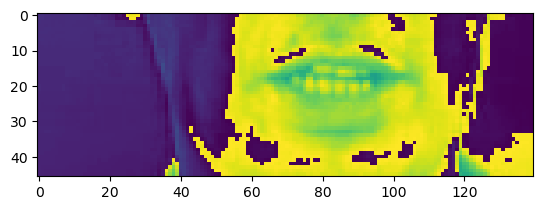

In [17]:
plt.imshow(frames[40])

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [21]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [22]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [23]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [24]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [25]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [26]:
draw_landmarks(frame, results)

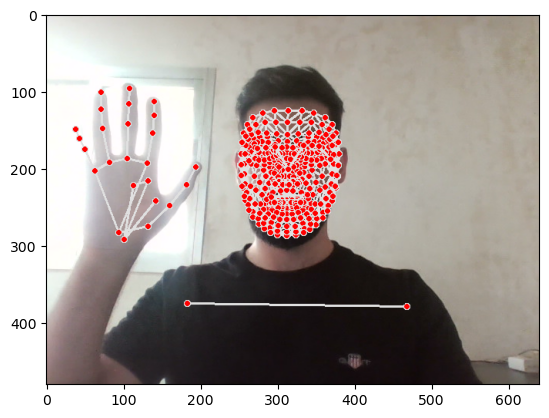

In [27]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [28]:
results.face_landmarks

landmark {
  x: 0.4882293
  y: 0.49761117
  z: -0.0248737
}
landmark {
  x: 0.48597035
  y: 0.4531148
  z: -0.04751194
}
landmark {
  x: 0.48751843
  y: 0.46668908
  z: -0.025078673
}
landmark {
  x: 0.47982454
  y: 0.40650705
  z: -0.034941416
}
landmark {
  x: 0.48591948
  y: 0.4388889
  z: -0.050471637
}
landmark {
  x: 0.48647177
  y: 0.42003447
  z: -0.04680434
}
landmark {
  x: 0.4884434
  y: 0.3749476
  z: -0.022781575
}
landmark {
  x: 0.42849618
  y: 0.37116787
  z: 0.015897073
}
landmark {
  x: 0.48936543
  y: 0.34454864
  z: -0.016489165
}
landmark {
  x: 0.4896811
  y: 0.32693708
  z: -0.018354114
}
landmark {
  x: 0.490636
  y: 0.26051265
  z: -0.0076317703
}
landmark {
  x: 0.48834354
  y: 0.5040926
  z: -0.023599662
}
landmark {
  x: 0.48851988
  y: 0.5084611
  z: -0.020495307
}
landmark {
  x: 0.4887966
  y: 0.5098268
  z: -0.016554698
}
landmark {
  x: 0.48884764
  y: 0.5100091
  z: -0.015729941
}
landmark {
  x: 0.48884246
  y: 0.5144264
  z: -0.01737649
}
landmark {


In [30]:
len(results.right_hand_landmarks.landmark)

21

In [31]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [32]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.ze

In [33]:
rh

array([ 1.47531614e-01,  5.90714097e-01,  2.64242487e-07,  2.07273543e-01,
        5.74487746e-01, -2.15796735e-02,  2.51508832e-01,  5.18011689e-01,
       -2.40003970e-02,  2.84751326e-01,  4.60747451e-01, -2.34240126e-02,
        3.03136438e-01,  4.13699746e-01, -2.26122849e-02,  2.05523297e-01,
        4.03819948e-01, -1.19682271e-02,  2.16883615e-01,  3.21886122e-01,
       -1.47879859e-02,  2.19006240e-01,  2.74706751e-01, -1.78250484e-02,
        2.19003126e-01,  2.36841470e-01, -2.15219706e-02,  1.65225893e-01,
        3.90721023e-01, -9.41270683e-03,  1.66621059e-01,  2.97766745e-01,
       -1.38409995e-02,  1.68487817e-01,  2.42314711e-01, -2.13260129e-02,
        1.69316560e-01,  2.00686365e-01, -2.70149689e-02,  1.28574029e-01,
        4.00263816e-01, -9.61738918e-03,  1.15077622e-01,  3.10171813e-01,
       -2.26361230e-02,  1.12161472e-01,  2.56489754e-01, -3.82201932e-02,
        1.11154281e-01,  2.11903915e-01, -4.82099652e-02,  9.91431922e-02,
        4.24642026e-01, -

In [34]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [35]:
result_test = extract_keypoints(results)

In [36]:
result_test

array([ 0.49165526,  0.41978991, -1.05523431, ...,  0.06046157,
        0.31078875, -0.04555668])

In [37]:
np.save('0', result_test)

In [38]:
np.load('0.npy')

array([ 0.49165526,  0.41978991, -1.05523431, ...,  0.06046157,
        0.31078875, -0.04555668])

In [39]:
# Actions that we try to detect
actions = np.array(['neutral', 'shift', 'stop-play'])

In [40]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Body_Data') 

# Actions that we try to detect
actions = np.array(['neutral', 'shifting', 'pausing'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0  # Start from the first folder

# Loop through each action
for action in actions: 
    # Construct the path to the action directory
    action_dir_path = os.path.join(DATA_PATH, action)   
    # If the action directory does not exist, create it
    if not os.path.exists(action_dir_path):
        os.makedirs(action_dir_path)
    # Create new directories numbered from 0 to 29
    for sequence in range(start_folder, start_folder + no_sequences):
        try: 
            os.makedirs(os.path.join(action_dir_path, str(sequence)))
        except FileExistsError:
            # If the directory already exists, do nothing
            pass


In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

#PIPELINE AND PREPROCESSING DATA 

In [41]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [42]:
len(test)

50

In [43]:
frames, alignments = data.as_numpy_iterator().next()

In [44]:
len(frames)

2

In [45]:
sample = data.as_numpy_iterator()

In [46]:
val = sample.next(); val[0]

array([[[[[1.5574893 ],
          [1.4850478 ],
          [1.4850478 ],
          ...,
          [0.3622068 ],
          [0.25354475],
          [0.25354475]],

         [[1.4850478 ],
          [1.3039445 ],
          [1.4126065 ],
          ...,
          [0.3622068 ],
          [0.25354475],
          [0.25354475]],

         [[1.4850478 ],
          [1.4850478 ],
          [1.5212686 ],
          ...,
          [0.3622068 ],
          [0.3984275 ],
          [0.3984275 ]],

         ...,

         [[1.0866205 ],
          [1.0866205 ],
          [1.0866205 ],
          ...,
          [0.10866204],
          [0.10866204],
          [0.10866204]],

         [[1.0503997 ],
          [1.0503997 ],
          [1.0503997 ],
          ...,
          [0.10866204],
          [0.10866204],
          [0.10866204]],

         [[1.0503997 ],
          [1.0503997 ],
          [1.0503997 ],
          ...,
          [0.10866204],
          [0.10866204],
          [0.07244136]]],


        [[[1.4126

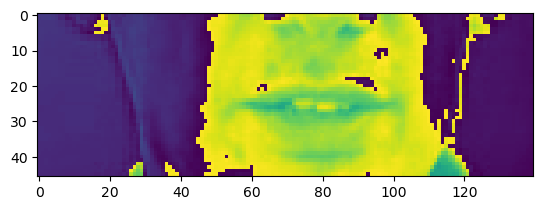

In [47]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [48]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with b four please'>

In [49]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [50]:
label_map = {label:num for num, label in enumerate(actions)}

In [51]:
label_map

{'neutral': 0, 'shifting': 1, 'pausing': 2}

In [52]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [53]:
np.array(sequences).shape

(90, 30, 1662)

In [54]:
np.array(labels).shape

(90,)

In [55]:
X = np.array(sequences)

In [56]:
X.shape

(90, 30, 1662)

In [57]:
y = to_categorical(labels).astype(int)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [59]:
y_test.shape

(5, 3)

In [60]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [61]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [62]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [70]:
5*17*75

6375

In [71]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [72]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'55555544444444444444454555555555555555555555555555555555555555555555544444d'>

In [73]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'55555544444444444444454555555555555555555555555555555555555555555555544444d'>

In [74]:
model.input_shape

(None, 75, 46, 140, 1)

In [75]:
model.output_shape

(None, 75, 41)

In [76]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [77]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [78]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [79]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [80]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [81]:
schedule_callback = LearningRateScheduler(scheduler)

In [82]:
example_callback = ProduceExample(test)

In [78]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  2/450 [..............................] - ETA: 6:32:02 - loss: 202.4690

Exception ignored in: <function PluginV3.__del__ at 0x000002833F798670>
Traceback (most recent call last):
  File "C:\Users\nabil\anaconda3\envs\vesionenv\lib\site-packages\imageio\core\v3_plugin_api.py", line 370, in __del__
    self.close()
KeyboardInterrupt: 

KeyboardInterrupt



In [83]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [84]:
modelB = Sequential()
modelB.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
modelB.add(LSTM(128, return_sequences=True, activation='relu'))
modelB.add(LSTM(64, return_sequences=False, activation='relu'))
modelB.add(Dense(64, activation='relu'))
modelB.add(Dense(32, activation='relu'))
modelB.add(Dense(actions.shape[0], activation='softmax'))

In [85]:
modelB.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [82]:
modelB.fit(X_train, y_train, epochs=600, callbacks=[tb_callback])

Epoch 1/600
3/3 [==============================] - 15s 1s/step - loss: 1.3076 - categorical_accuracy: 0.4000
Epoch 2/600
3/3 [==============================] - 5s 1s/step - loss: 9.6713 - categorical_accuracy: 0.3412
Epoch 3/600
2/3 [===================>..........] - ETA: 2s - loss: 1.1247 - categorical_accuracy: 0.3438

KeyboardInterrupt: 

#Model Summary

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [87]:
modelB.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

#Load models and checkpoints

In [88]:
output = 'checkpoints.zip'
gdown.extractall('checkpoints.zip', 'models')

['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [89]:
model.load_weights('models/checkpoint')

In [90]:
modelB.load_weights('body.h5')

#Evaluation and accuracy

In [91]:
test_data = test.as_numpy_iterator()

In [92]:
sample = test_data.next()

In [93]:
yhat = model.predict(sample[0])

1/1 [==============================] - 8s 8s/step


In [94]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by c three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with l two please'>]

In [95]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [96]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by c three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with l two please'>]

In [97]:
res = modelB.predict(X_test)

1/1 [==============================] - 1s 994ms/step


In [98]:
actions[np.argmax(res[4])]

'neutral'

In [99]:
actions[np.argmax(y_test[4])]

'neutral'

In [100]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [101]:
yhat = modelB.predict(X_test)

1/1 [==============================] - 0s 58ms/step


In [102]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [103]:
accuracy_score(ytrue, yhat)

1.0

#Video and real time test

In [104]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [105]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [106]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [107]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [108]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [109]:
from scipy import stats

In [110]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [111]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = modelB.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

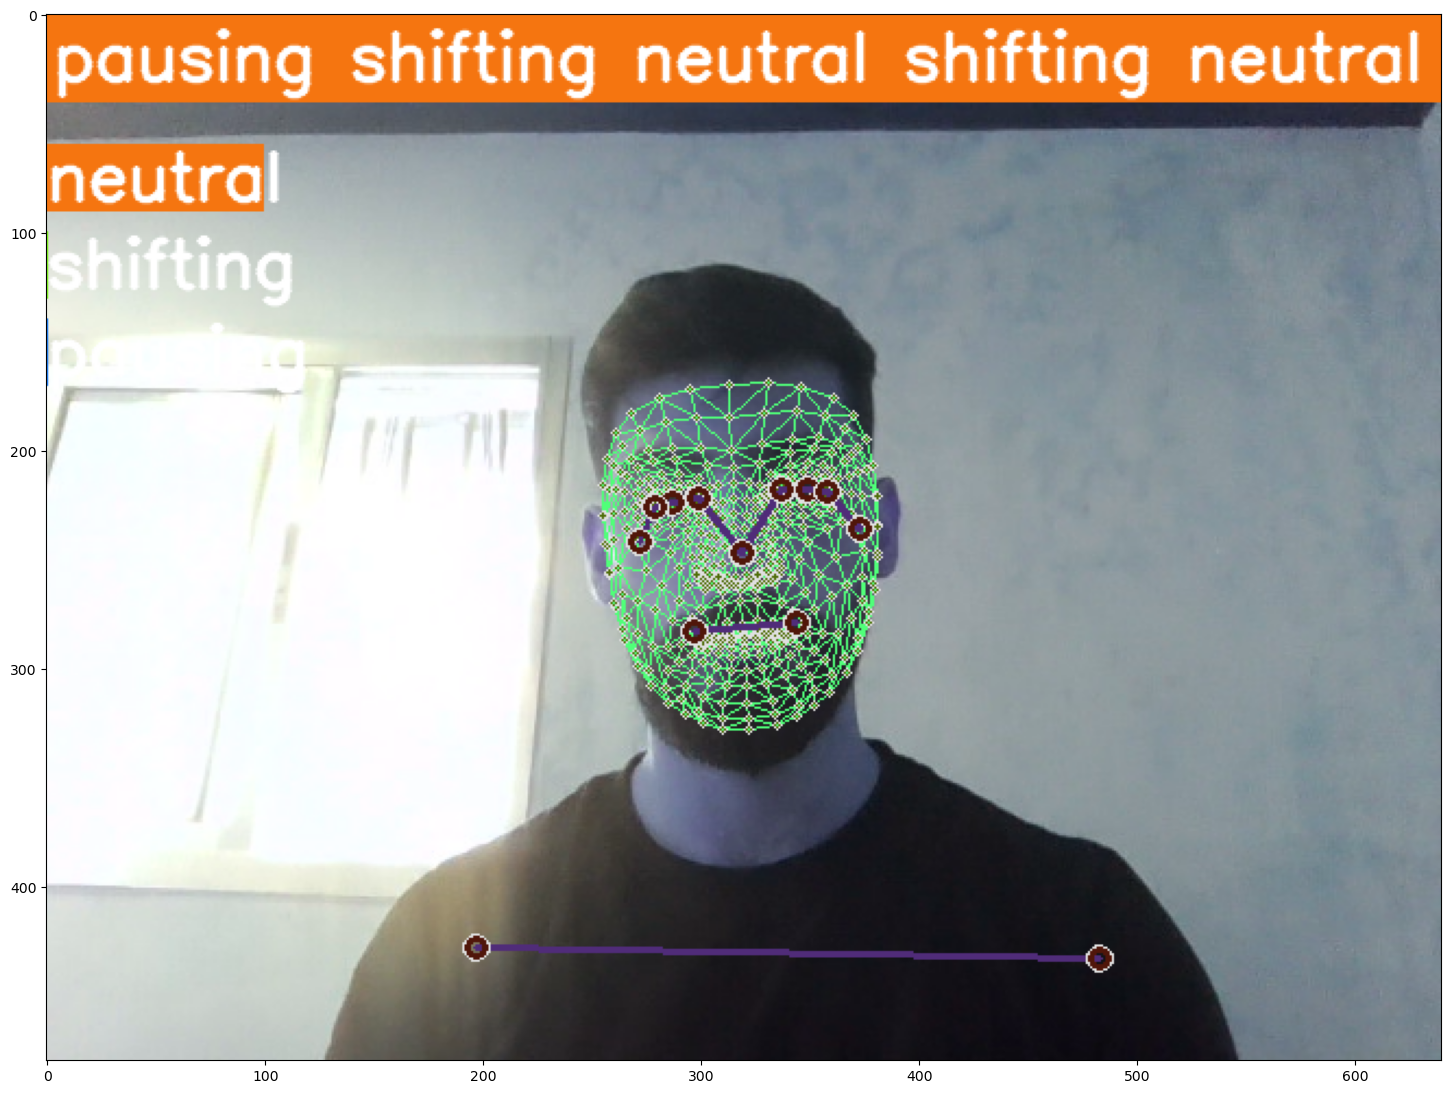

In [112]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [113]:
%%writefile vision9c.py
import subprocess
from subprocess import run
import time
from typing import List
import gdown
import streamlit as st
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
import tensorflow as tf
from PIL import Image
import os 
import imageio 
from utils import load_data, num_to_char
from modelutil import load_model

# Initialize MediaPipe holistic
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def convert_video_to_compatible_format(input_video_path):
    output_video_path = os.path.splitext(input_video_path)[0] + '_compatible.mp4'
    command = [
        'ffmpeg',
        '-i', input_video_path,
        '-c:v', 'libx264',
        '-preset', 'fast',
        '-pix_fmt', 'yuv420p',
        output_video_path,
        '-y'
    ]
    try:
        run(command, check=True)
        return output_video_path
    except subprocess.CalledProcessError as e:
        st.error(f"FFmpeg error: {e}")
        return None

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 
def draw_styled_landmarks(image, results):    
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )     
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )     
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

model = tf.keras.models.load_model('body.h5')
# Actions that we try to detect
actions = np.array(['neutral', 'shifting', 'pausing'])

# Process video and apply action recognition
def process_video(video_file):
    # Convert the uploaded video to a compatible format
    converted_video_path = convert_video_to_compatible_format(video_file.name)
    if not converted_video_path:
        st.error("Video conversion failed. Please check the video format.")
        st.stop()

    cap = cv2.VideoCapture(converted_video_path)
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5
    colors = [(245,117,16), (117,245,16), (16,117,245)]
    processed_frames_with_labels = []

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            
            # Draw landmarks
            draw_styled_landmarks(image, results)
            
            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]  # Keep last 30 frames
            
            if len(sequence) == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                
                # Visualization logic
                if np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5: 
                    sentence = sentence[-5:]

                # Viz probabilities and add action labels to the frame
                image_with_labels = prob_viz(res, actions, image, colors)
                processed_frames_with_labels.append(image_with_labels)

        cap.release()

    # Check if the list is not empty before accessing
    if processed_frames_with_labels:
        height, width, layers = processed_frames_with_labels[0].shape
        size = (width, height)
        
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        processed_video_path = 'processed_video_with_actions.mp4'
        out = cv2.VideoWriter(processed_video_path, fourcc, 15, size)
        
        for frame in processed_frames_with_labels:
            out.write(frame)
        out.release()
        
        # Convert the processed video to a compatible format using ffmpeg
        final_video_path = 'final_video_with_actions.mp4'
        run(['ffmpeg', '-i', processed_video_path, '-vcodec', 'libx264', final_video_path, '-y'])
        
        # Remove the temporary processed video file
        os.remove(processed_video_path)
        
        return final_video_path
    else:
        st.error("No frames were processed. Please check the video file and try again.")
        return None
#############################################################################################################################################        
st.set_page_config(layout='wide')

with st.sidebar: 
    
    st.title('ROBOTIC-VISION')
    st.info('This application is originally for developing smart analyses systems.')

# Initialize session states for each tab if not already present
if 'tab1_state' not in st.session_state:
    st.session_state['tab1_state'] = None

if 'tab2_state' not in st.session_state:
    st.session_state['tab2_state'] = None

# Define the sidebar options
sidebar_options = ["Lip detection", "Body detection"]
selected_option = st.sidebar.selectbox("Choose an option:", sidebar_options)

# Define a sidebar button for capture
if st.sidebar.button("Live Body Detection"):
    st.session_state['Live Body Detection'] = True
else:
    st.session_state['Live Body Detection'] = False

if selected_option == "Lip detection":
    st.session_state['tab1_state'] = "active"
    st.session_state['tab2_state'] = None
    st.title('Lip Reading and Analysis')  
    options = os.listdir(os.path.join('data', 's1'))
    selected_video = st.selectbox('Choose video for lip reading', options, key='video_selection_tab1')
    if options:
        st.info('The video below displays the converted video in mp4 format for lip reading')
        file_path = os.path.join('data', 's1', selected_video)
        converted_video_path = convert_video_to_compatible_format(file_path)
        if converted_video_path:
            video_file = open(converted_video_path, 'rb')
            video_bytes = video_file.read()
            st.video(video_bytes)
            video_file.close()  # Close the file after reading

        st.info('This is all the machine learning model sees when making a prediction for lip reading')
        video, annotations = load_data(tf.convert_to_tensor(file_path))
        
        st.image('animation.gif', width=400) 
        st.info('This is the output of the machine learning model as tokens for lip reading')
        model = load_model()
        yhat = model.predict(tf.expand_dims(video, axis=0))
        decoder = tf.keras.backend.ctc_decode(yhat, [75], greedy=True)[0][0].numpy()
        st.text(decoder)
        # Convert prediction to text
        st.info('Decode the raw tokens into words for lip reading')
        converted_prediction = tf.strings.reduce_join(num_to_char(decoder)).numpy().decode('utf-8')
        st.text(converted_prediction)

elif selected_option == "Body detection":
    st.session_state['tab1_state'] = None
    st.session_state['tab2_state'] = "active"
    st.info('The video below displays the processed video with landmarks and actions')
    uploaded_video = st.file_uploader("Upload a video", type=["mp4", "mpg", "mpeg..."])
    if uploaded_video is not None:
        # Save the uploaded video to a temporary file
        with open(uploaded_video.name, "wb") as f:
            f.write(uploaded_video.getbuffer())
        
        # Process video and display processed video with landmarks and actions
        processed_video_path = process_video(uploaded_video)
        if processed_video_path:
            st.video(processed_video_path)

        # Clean up temporary files
        if os.path.exists(uploaded_video.name):
            os.remove(uploaded_video.name)
        if processed_video_path and os.path.exists(processed_video_path):
            os.remove(processed_video_path)
            
if st.session_state['Live Body Detection']:
    def ld_model(model_path):
        model = tf.keras.models.load_model(model_path)
        return model
    
    # Later, when you want to use the model
    model_path = 'body.h5'  # Specify the correct path to your model weights
    loaded_model = ld_model(model_path)
    # Actions that we try to detect
    actions = np.array(['neutral', 'shifting', 'pausing'])
    colors = [(245,117,16), (117,245,16), (16,117,245)]
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5  
    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
    
            # Read feed
            ret, frame = cap.read()
    
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            
            # Draw landmarks
            draw_styled_landmarks(image, results)
    
            # 2. Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            
            if len(sequence) == 30:
                res = loaded_model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
    
                # 3. Viz logic
                if len(predictions) >= 10 and np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        
                        action = actions[np.argmax(res)]
                        if action == 'pausing':
                            display_action = 'off'
                        elif action == 'shifting':
                            display_action = 'on'
                        else:
                            display_action = action
    
                        if len(sentence) > 0: 
                            if display_action != sentence[-1]:
                                sentence.append(display_action)
                        else:
                            sentence.append(display_action)
        
                    if len(sentence) > 5: 
                        sentence = sentence[-5:]
        
                    # Viz probabilities
                    image = prob_viz(res, actions, image, colors)
                    
                cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
                cv2.putText(image, ' '.join(sentence), (3,30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
    
            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
    

Overwriting vision9c.py


In [ ]:
! streamlit run vision9c.py